In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

max_min = 40 #min
min_min = 5 #min
n_files = max_min-min_min+1
data = {}

dir_path_eune = os.path.join(os.getcwd(), "data", "eun1")
dir_path_euw = os.path.join(os.getcwd(), "data", "euw1")
dir_path_na = os.path.join(os.getcwd(), "data", "na1")
dir_path_kr = os.path.join(os.getcwd(), "data", "kr")

max_min = 40 #min
min_min = 5 #min
n_files = max_min-min_min+1
data_eune = {}
data_euw = {}
data_na = {}
data_kr = {}

for i in range(n_files):
    data_eune["data_"+str(5+i)+"min"] = pd.read_csv(os.path.join(dir_path_eune, "match_summary_"+str(5+i)+"min_eun1.csv"), 
                                               dtype=int, 
                                               index_col=0)
    data_euw["data_"+str(5+i)+"min"] = pd.read_csv(os.path.join(dir_path_euw, "match_summary_"+str(5+i)+"min_euw1.csv"), 
                                               dtype=int, 
                                               index_col=0)
    data_na["data_"+str(5+i)+"min"] = pd.read_csv(os.path.join(dir_path_na, "match_summary_"+str(5+i)+"min_na1.csv"), 
                                               dtype=int, 
                                               index_col=0)
    data_kr["data_"+str(5+i)+"min"] = pd.read_csv(os.path.join(dir_path_kr, "match_summary_"+str(5+i)+"min_kr.csv"), 
                                               dtype=int, 
                                               index_col=0)

In another notebook we have determined that a support vector machine classifier seems to work best.

In [3]:
def train_test_split_random(X, y, test_ratio=0.1, random_seed=42):
    np.random.seed(seed=random_seed)
    shuffled_indices = np.random.permutation(len(X))
    test_num = int(np.round(test_ratio*len(X)))
    X_test = X[shuffled_indices[:test_num]]
    y_test = y[shuffled_indices[:test_num]]
    X_train = X[shuffled_indices[test_num:]]
    y_train = y[shuffled_indices[test_num:]]
    
    return X_test, y_test, X_train, y_train

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
import sys
from sklearn.model_selection import GridSearchCV

rfc=RandomForestClassifier()

classifiers_eun = []
classifiers_euw = []
classifiers_na = []
classifiers_kr = []
accuracy_train_eun = []
accuracy_train_euw = []
accuracy_train_na = []
accuracy_train_kr = []
accuracy_test_eun = []
accuracy_test_euw = []
accuracy_test_na = []
accuracy_test_kr = []

for (i, key) in enumerate(data_eune):

    dat_eun = data_eune[key]
    dat_euw = data_euw[key]
    dat_na = data_na[key]
    dat_kr = data_kr[key]
    
    y_eun = np.array(dat_eun["blueWin"])
    y_euw = np.array(dat_euw["blueWin"])
    y_na = np.array(dat_na["blueWin"])
    y_kr = np.array(dat_kr["blueWin"])
    X_eun = dat_eun.drop("blueWin", axis=1).values
    X_euw = dat_euw.drop("blueWin", axis=1).values
    X_na = dat_na.drop("blueWin", axis=1).values
    X_kr = dat_kr.drop("blueWin", axis=1).values
    
    X_test_eun, y_test_eun, X_train_eun, y_train_eun = train_test_split_random(X_eun, y_eun)
    X_test_euw, y_test_euw, X_train_euw, y_train_euw = train_test_split_random(X_euw, y_euw)
    X_test_na, y_test_na, X_train_na, y_train_na = train_test_split_random(X_na, y_na)
    X_test_kr, y_test_kr, X_train_kr, y_train_kr = train_test_split_random(X_kr, y_kr)
    
    rfc_clone = clone(rfc)
    
    param_grid_rfc = [
        {'n_estimators': [10, 20, 30, 50], 'max_depth': [30, 50, 70, 90], "max_leaf_nodes": [10, 20, 30, 40]}
        ]
    grid_search_rfc_eun = GridSearchCV(rfc_clone, param_grid_rfc, cv=3, n_jobs=-1, scoring="accuracy", iid='deprecated')
    grid_search_rfc_eun.fit(X_train_eun, y_train_eun)    
    best_clf_eun = grid_search_rfc_eun.best_estimator_
    
    grid_search_rfc_euw = GridSearchCV(rfc_clone, param_grid_rfc, cv=3, n_jobs=-1, scoring="accuracy", iid='deprecated')
    grid_search_rfc_euw.fit(X_train_euw, y_train_euw)    
    best_clf_euw = grid_search_rfc_euw.best_estimator_
    
    grid_search_rfc_na = GridSearchCV(rfc_clone, param_grid_rfc, cv=3, n_jobs=-1, scoring="accuracy", iid='deprecated')
    grid_search_rfc_na.fit(X_train_na, y_train_na)    
    best_clf_na = grid_search_rfc_na.best_estimator_
    
    grid_search_rfc_kr = GridSearchCV(rfc_clone, param_grid_rfc, cv=3, n_jobs=-1, scoring="accuracy", iid='deprecated')
    grid_search_rfc_kr.fit(X_train_kr, y_train_kr)    
    best_clf_kr = grid_search_rfc_kr.best_estimator_
    
    classifiers_eun.append((i+5, best_clf_eun))
    classifiers_euw.append((i+5, best_clf_euw))
    classifiers_na.append((i+5, best_clf_na))
    classifiers_kr.append((i+5, best_clf_kr))
    
    best_clf_eun.fit(X_train_eun, y_train_eun)
    best_clf_euw.fit(X_train_euw, y_train_euw)
    best_clf_na.fit(X_train_na, y_train_na)
    best_clf_kr.fit(X_train_kr, y_train_kr)
    
    accuracy_train_eun.append((i+5, np.round(np.mean(best_clf_eun.predict(X_train_eun)==y_train_eun)*100, 2)))
    accuracy_test_eun.append((i+5, np.round(np.mean(best_clf_eun.predict(X_test_eun)==y_test_eun)*100, 2)))
    
    accuracy_train_euw.append((i+5, np.round(np.mean(best_clf_euw.predict(X_train_euw)==y_train_euw)*100, 2)))
    accuracy_test_euw.append((i+5, np.round(np.mean(best_clf_euw.predict(X_test_euw)==y_test_euw)*100, 2)))
    
    accuracy_train_na.append((i+5, np.round(np.mean(best_clf_na.predict(X_train_na)==y_train_na)*100, 2)))
    accuracy_test_na.append((i+5, np.round(np.mean(best_clf_na.predict(X_test_na)==y_test_na)*100, 2)))
    
    accuracy_train_kr.append((i+5, np.round(np.mean(best_clf_kr.predict(X_train_kr)==y_train_kr)*100, 2)))
    accuracy_test_kr.append((i+5, np.round(np.mean(best_clf_kr.predict(X_test_kr)==y_test_kr)*100, 2)))
    
    sys.stdout.write("\rProcessed: "+str(i + 5)+" of 40 min. Accuracy for "+str(i+5)+" is: "+str(np.round(np.mean(best_clf_eun.predict(X_train_eun)==y_train_eun)*100, 2))+"%.")
    sys.stdout.flush()

Processed: 40 of 40 min. Accuracy for 40 is: 87.43%.

Let´s check the accuracy of the models at different minutes.

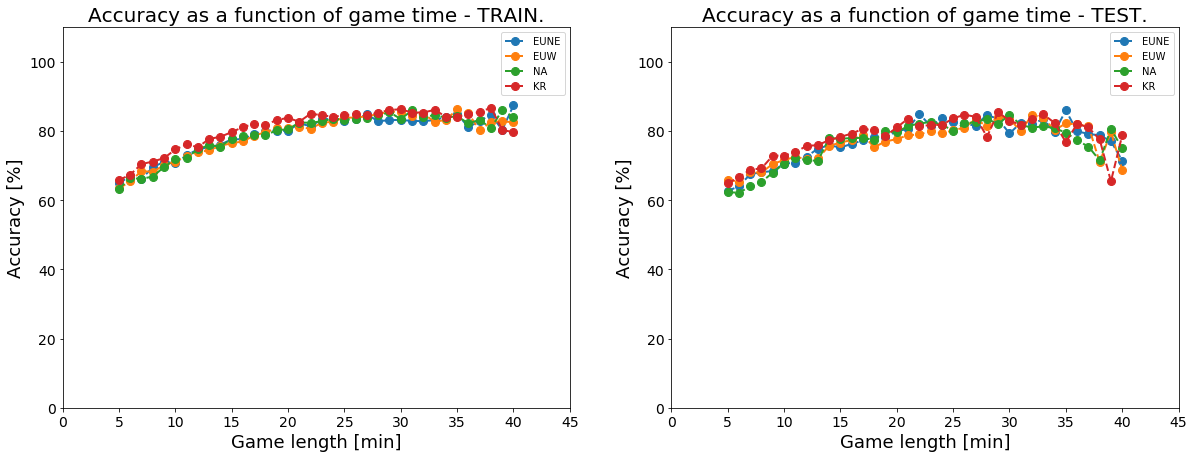

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
ax[0].set_title("Accuracy as a function of game time - TRAIN.", fontsize =20)
ax[1].set_title("Accuracy as a function of game time - TEST.", fontsize =20)

ax[0].plot([time for (time, acc) in accuracy_train_eun], 
        [acc for (time, acc) in accuracy_train_eun], 
        marker='o', linestyle='dashed', linewidth=2, 
        markersize=8)
ax[0].plot([time for (time, acc) in accuracy_train_euw], 
        [acc for (time, acc) in accuracy_train_euw], 
        marker='o', linestyle='dashed', linewidth=2, 
        markersize=8)
ax[0].plot([time for (time, acc) in accuracy_train_na], 
        [acc for (time, acc) in accuracy_train_na], 
        marker='o', linestyle='dashed', linewidth=2, 
        markersize=8)
ax[0].plot([time for (time, acc) in accuracy_train_kr], 
        [acc for (time, acc) in accuracy_train_kr], 
        marker='o', linestyle='dashed', linewidth=2, 
        markersize=8)

ax[1].plot([time for (time, acc) in accuracy_test_eun], 
        [acc for (time, acc) in accuracy_test_eun], 
        marker='o', linestyle='dashed', linewidth=2, 
        markersize=8)
ax[1].plot([time for (time, acc) in accuracy_test_euw], 
        [acc for (time, acc) in accuracy_test_euw], 
        marker='o', linestyle='dashed', linewidth=2, 
        markersize=8)
ax[1].plot([time for (time, acc) in accuracy_test_na], 
        [acc for (time, acc) in accuracy_test_na], 
        marker='o', linestyle='dashed', linewidth=2, 
        markersize=8)
ax[1].plot([time for (time, acc) in accuracy_test_kr], 
        [acc for (time, acc) in accuracy_test_kr], 
        marker='o', linestyle='dashed', linewidth=2, 
        markersize=8)

ax[0].legend(["EUNE", "EUW", "NA", "KR"])
ax[0].set_xticklabels([0, 5, 10, 15, 20, 25, 30, 35, 40, 45], fontsize=14)
ax[0].set_xlim(0, 45)
ax[0].set_ylim(0, 110)
ax[0].set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=14)
ax[0].set_xlabel("Game length [min]", fontsize=18)
ax[0].set_ylabel("Accuracy [%]", fontsize=18)

ax[1].legend(["EUNE", "EUW", "NA", "KR"])
ax[1].set_xticklabels([0, 5, 10, 15, 20, 25, 30, 35, 40, 45], fontsize=14)
ax[1].set_xlim(0, 45)
ax[1].set_ylim(0, 110)
ax[1].set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=14)
ax[1].set_xlabel("Game length [min]", fontsize=18)
ax[1].set_ylabel("Accuracy [%]", fontsize=18)
plt.show()

Interestingly enough, the prediction accuracy starts to fall after around 30 minutes. This can be explained by the following reasoning. After about 30 minutes the player timers after death for respawn can be as long as one minute. This means that if something unexpected happens (ie. the team that is behind getting an objective or killing players from the opposing team) the fortunes of the game can quickly spiral out of control. This of course introduces some randomness into the game, making the outcome more difficult to predict.

This same thing was already observed in the ***Data Expolarition*** notebook where we saw that the correlations between features and winning the game decreased after about 30 min of play.

In [9]:
features = list(data_eune["data_5min"].keys())[1:]

coeffs_eun = [clf.feature_importances_ for (time, clf) in classifiers_eun]
coefficients_eun = {key: [] for key in features}

for array in coeffs_eun:
    for (i, key) in enumerate(features):
        coefficients_eun[key].append(array[i])
        
coeffs_euw = [clf.feature_importances_ for (time, clf) in classifiers_euw]
coefficients_euw = {key: [] for key in features}

for array in coeffs_euw:
    for (i, key) in enumerate(features):
        coefficients_euw[key].append(array[i])
        
coeffs_na = [clf.feature_importances_ for (time, clf) in classifiers_na]
coefficients_na = {key: [] for key in features}

for array in coeffs_na:
    for (i, key) in enumerate(features):
        coefficients_na[key].append(array[i])
        
coeffs_kr = [clf.feature_importances_ for (time, clf) in classifiers_kr]
coefficients_kr = {key: [] for key in features}

for array in coeffs_kr:
    for (i, key) in enumerate(features):
        coefficients_kr[key].append(array[i])

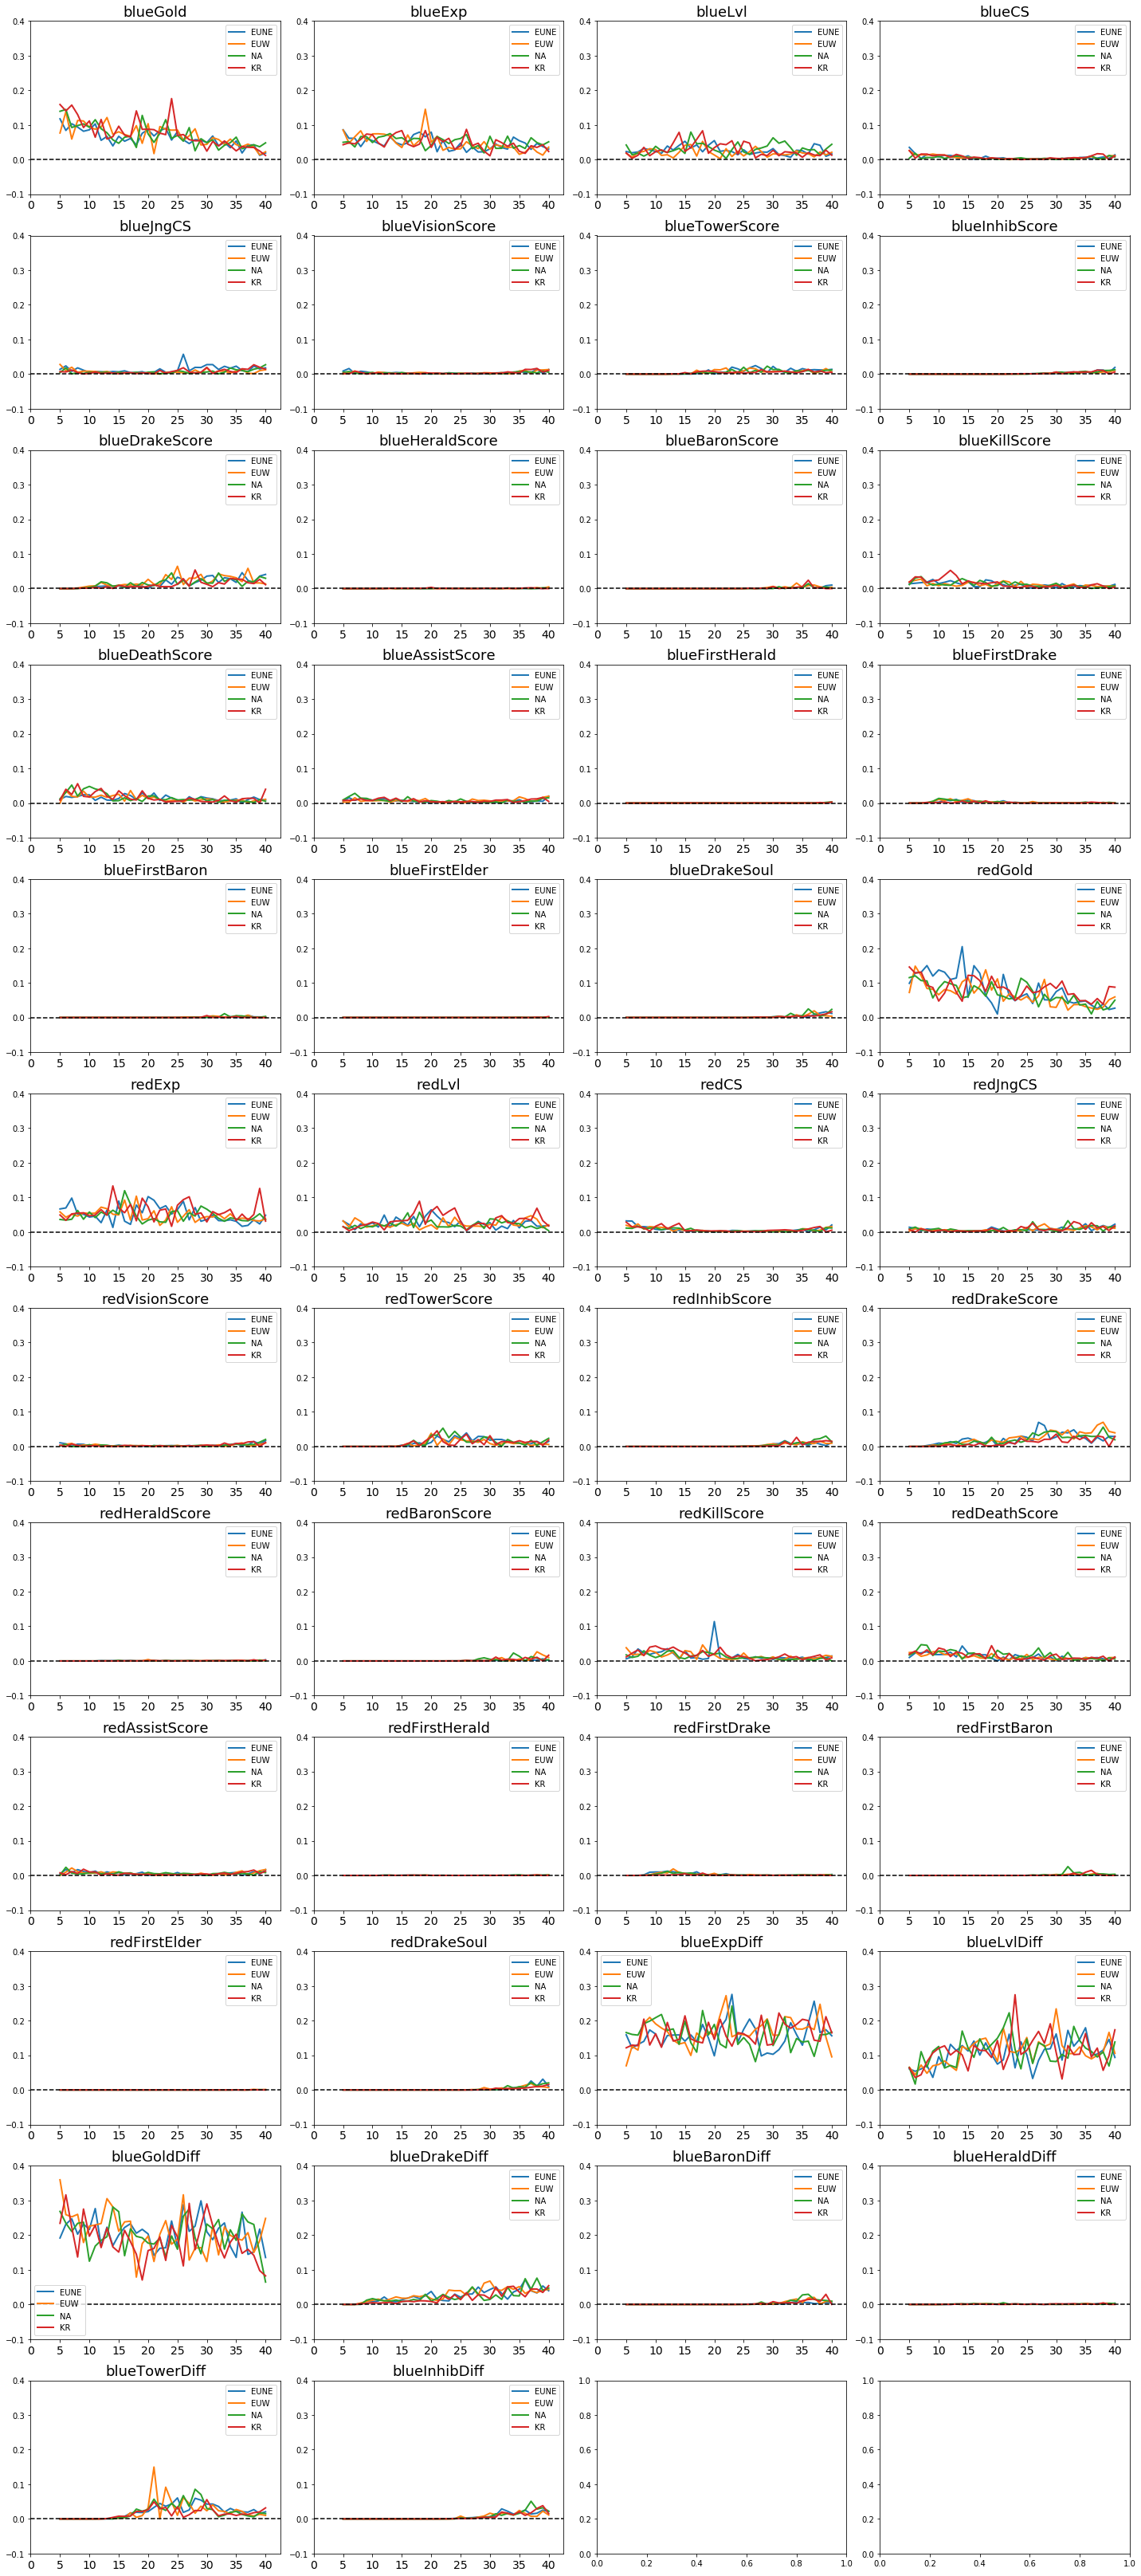

In [11]:
n_rows = 12
n_columns = 4
x_axis = [i+5 for i in range(len(coeffs_kr))]
corr_index = np.array([i for i in range(n_rows*n_columns)]).reshape((n_rows, -1))

fig, ax = plt.subplots(n_rows, n_columns, figsize=(20,45))

for k in range(n_rows):
    for l in range(n_columns):
        try:
            feature = features[corr_index[k, l]]
            ax[k, l].set_title(feature, fontsize=18)
            ax[k, l].plot(x_axis, coefficients_eun[feature], linestyle='-', linewidth=2)
            ax[k, l].plot(x_axis, coefficients_euw[feature], linestyle='-', linewidth=2)
            ax[k, l].plot(x_axis, coefficients_na[feature], linestyle='-', linewidth=2)
            ax[k, l].plot(x_axis, coefficients_kr[feature], linestyle='-', linewidth=2)
            ax[k, l].set_xlim(0, 42.5)
            ax[k, l].set_xticklabels([0, 5, 10, 15, 20, 25, 30, 35, 40], fontsize=14)
            ax[k, l].set_ylim(-0.1, 0.4)
            ax[k, l].axhline(y = 0, linestyle="--", color="black")
            ax[k, l].legend(["EUNE", "EUW", "NA", "KR"])
        except:
            pass
plt.tight_layout()      
plt.show()

We can see that the feature importances of each server/region are not really that different. This means we can most probably group all the games from all the servers into one unified training and testing dataset.

# Grouped Data

In [19]:
rfc=RandomForestClassifier()

classifiers = []
accuracy_train = []
accuracy_test = []

for (i, key) in enumerate(data_eune):

    dat_eun = data_eune[key]
    dat_euw = data_euw[key]
    dat_na = data_na[key]
    dat_kr = data_kr[key]
    
    y_eun = np.array(dat_eun["blueWin"])
    y_euw = np.array(dat_euw["blueWin"])
    y_na = np.array(dat_na["blueWin"])
    y_kr = np.array(dat_kr["blueWin"])
    X_eun = dat_eun.drop("blueWin", axis=1).values
    X_euw = dat_euw.drop("blueWin", axis=1).values
    X_na = dat_na.drop("blueWin", axis=1).values
    X_kr = dat_kr.drop("blueWin", axis=1).values
    
    X = np.concatenate((X_eun, X_euw, X_na, X_kr),axis=0)
    y = np.concatenate((y_eun, y_euw, y_na, y_kr),axis=0)
    
    X_test, y_test, X_train, y_train = train_test_split_random(X, y)
    
    rfc_clone = clone(rfc)
    
    param_grid_rfc = [
        {'n_estimators': [10, 20, 30, 50], 'max_depth': [30, 50, 70, 90], "max_leaf_nodes": [10, 20, 30, 40]}
        ]
    grid_search_rfc = GridSearchCV(rfc_clone, param_grid_rfc, cv=3, n_jobs=-1, scoring="accuracy", iid='deprecated')
    grid_search_rfc.fit(X_train, y_train)    
    best_clf = grid_search_rfc.best_estimator_
    
    classifiers.append((i+5, best_clf))
    
    best_clf.fit(X_train, y_train)
    
    accuracy_train.append((i+5, np.round(np.mean(best_clf.predict(X_train)==y_train)*100, 2)))
    accuracy_test.append((i+5, np.round(np.mean(best_clf.predict(X_test)==y_test)*100, 2)))
    
    sys.stdout.write("\rProcessed: "+str(i + 5)+" of 40 min. Accuracy for "+str(i+5)+" is: "+str(np.round(np.mean(best_clf.predict(X_train)==y_train)*100, 2))+"%.")
    sys.stdout.flush()

Processed: 40 of 40 min. Accuracy for 40 is: 81.1%..

Now let´s again check the accuracy and see if it increases with the 4 times larger dataset.

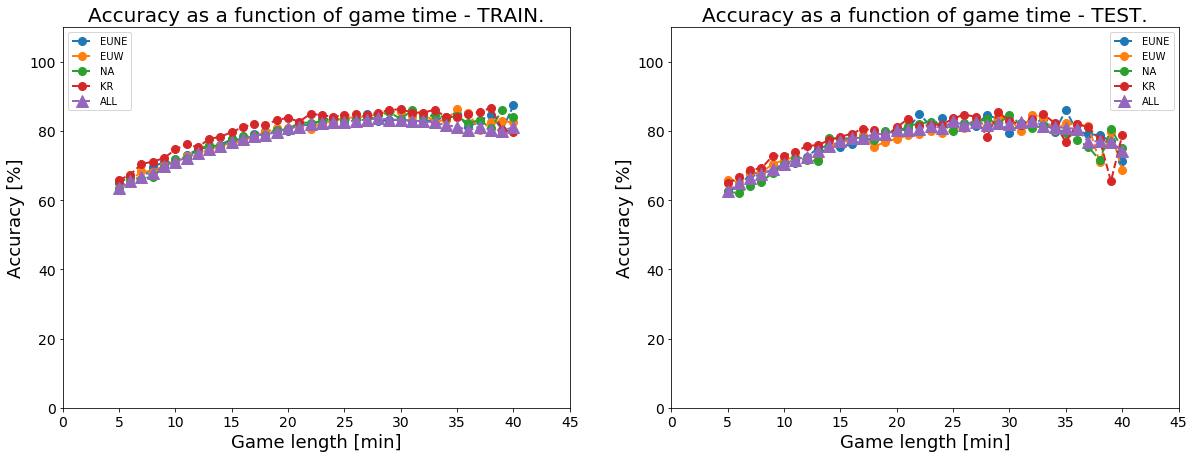

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
ax[0].set_title("Accuracy as a function of game time - TRAIN.", fontsize =20)
ax[1].set_title("Accuracy as a function of game time - TEST.", fontsize =20)

ax[0].plot([time for (time, acc) in accuracy_train_eun], 
        [acc for (time, acc) in accuracy_train_eun], 
        marker='o', linestyle='dashed', linewidth=2, 
        markersize=8)
ax[0].plot([time for (time, acc) in accuracy_train_euw], 
        [acc for (time, acc) in accuracy_train_euw], 
        marker='o', linestyle='dashed', linewidth=2, 
        markersize=8)
ax[0].plot([time for (time, acc) in accuracy_train_na], 
        [acc for (time, acc) in accuracy_train_na], 
        marker='o', linestyle='dashed', linewidth=2, 
        markersize=8)
ax[0].plot([time for (time, acc) in accuracy_train_kr], 
        [acc for (time, acc) in accuracy_train_kr], 
        marker='o', linestyle='dashed', linewidth=2, 
        markersize=8)
ax[0].plot([time for (time, acc) in accuracy_train], 
        [acc for (time, acc) in accuracy_train], 
        marker='^', linestyle='dashed', linewidth=2, 
        markersize=12)

ax[1].plot([time for (time, acc) in accuracy_test_eun], 
        [acc for (time, acc) in accuracy_test_eun], 
        marker='o', linestyle='dashed', linewidth=2, 
        markersize=8)
ax[1].plot([time for (time, acc) in accuracy_test_euw], 
        [acc for (time, acc) in accuracy_test_euw], 
        marker='o', linestyle='dashed', linewidth=2, 
        markersize=8)
ax[1].plot([time for (time, acc) in accuracy_test_na], 
        [acc for (time, acc) in accuracy_test_na], 
        marker='o', linestyle='dashed', linewidth=2, 
        markersize=8)
ax[1].plot([time for (time, acc) in accuracy_test_kr], 
        [acc for (time, acc) in accuracy_test_kr], 
        marker='o', linestyle='dashed', linewidth=2, 
        markersize=8)
ax[1].plot([time for (time, acc) in accuracy_test], 
        [acc for (time, acc) in accuracy_test], 
        marker='^', linestyle='dashed', linewidth=2, 
        markersize=12)

ax[0].legend(["EUNE", "EUW", "NA", "KR", "ALL"])
ax[0].set_xticklabels([0, 5, 10, 15, 20, 25, 30, 35, 40, 45], fontsize=14)
ax[0].set_xlim(0, 45)
ax[0].set_ylim(0, 110)
ax[0].set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=14)
ax[0].set_xlabel("Game length [min]", fontsize=18)
ax[0].set_ylabel("Accuracy [%]", fontsize=18)

ax[1].legend(["EUNE", "EUW", "NA", "KR", "ALL"])
ax[1].set_xticklabels([0, 5, 10, 15, 20, 25, 30, 35, 40, 45], fontsize=14)
ax[1].set_xlim(0, 45)
ax[1].set_ylim(0, 110)
ax[1].set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=14)
ax[1].set_xlabel("Game length [min]", fontsize=18)
ax[1].set_ylabel("Accuracy [%]", fontsize=18)
plt.show()

Despite increasing the dataset by 4 times, the accuracy doesnt really improve much. Only the plot is a little less bumpy.

Let´s also check how the feature importances as a function of game time look now.

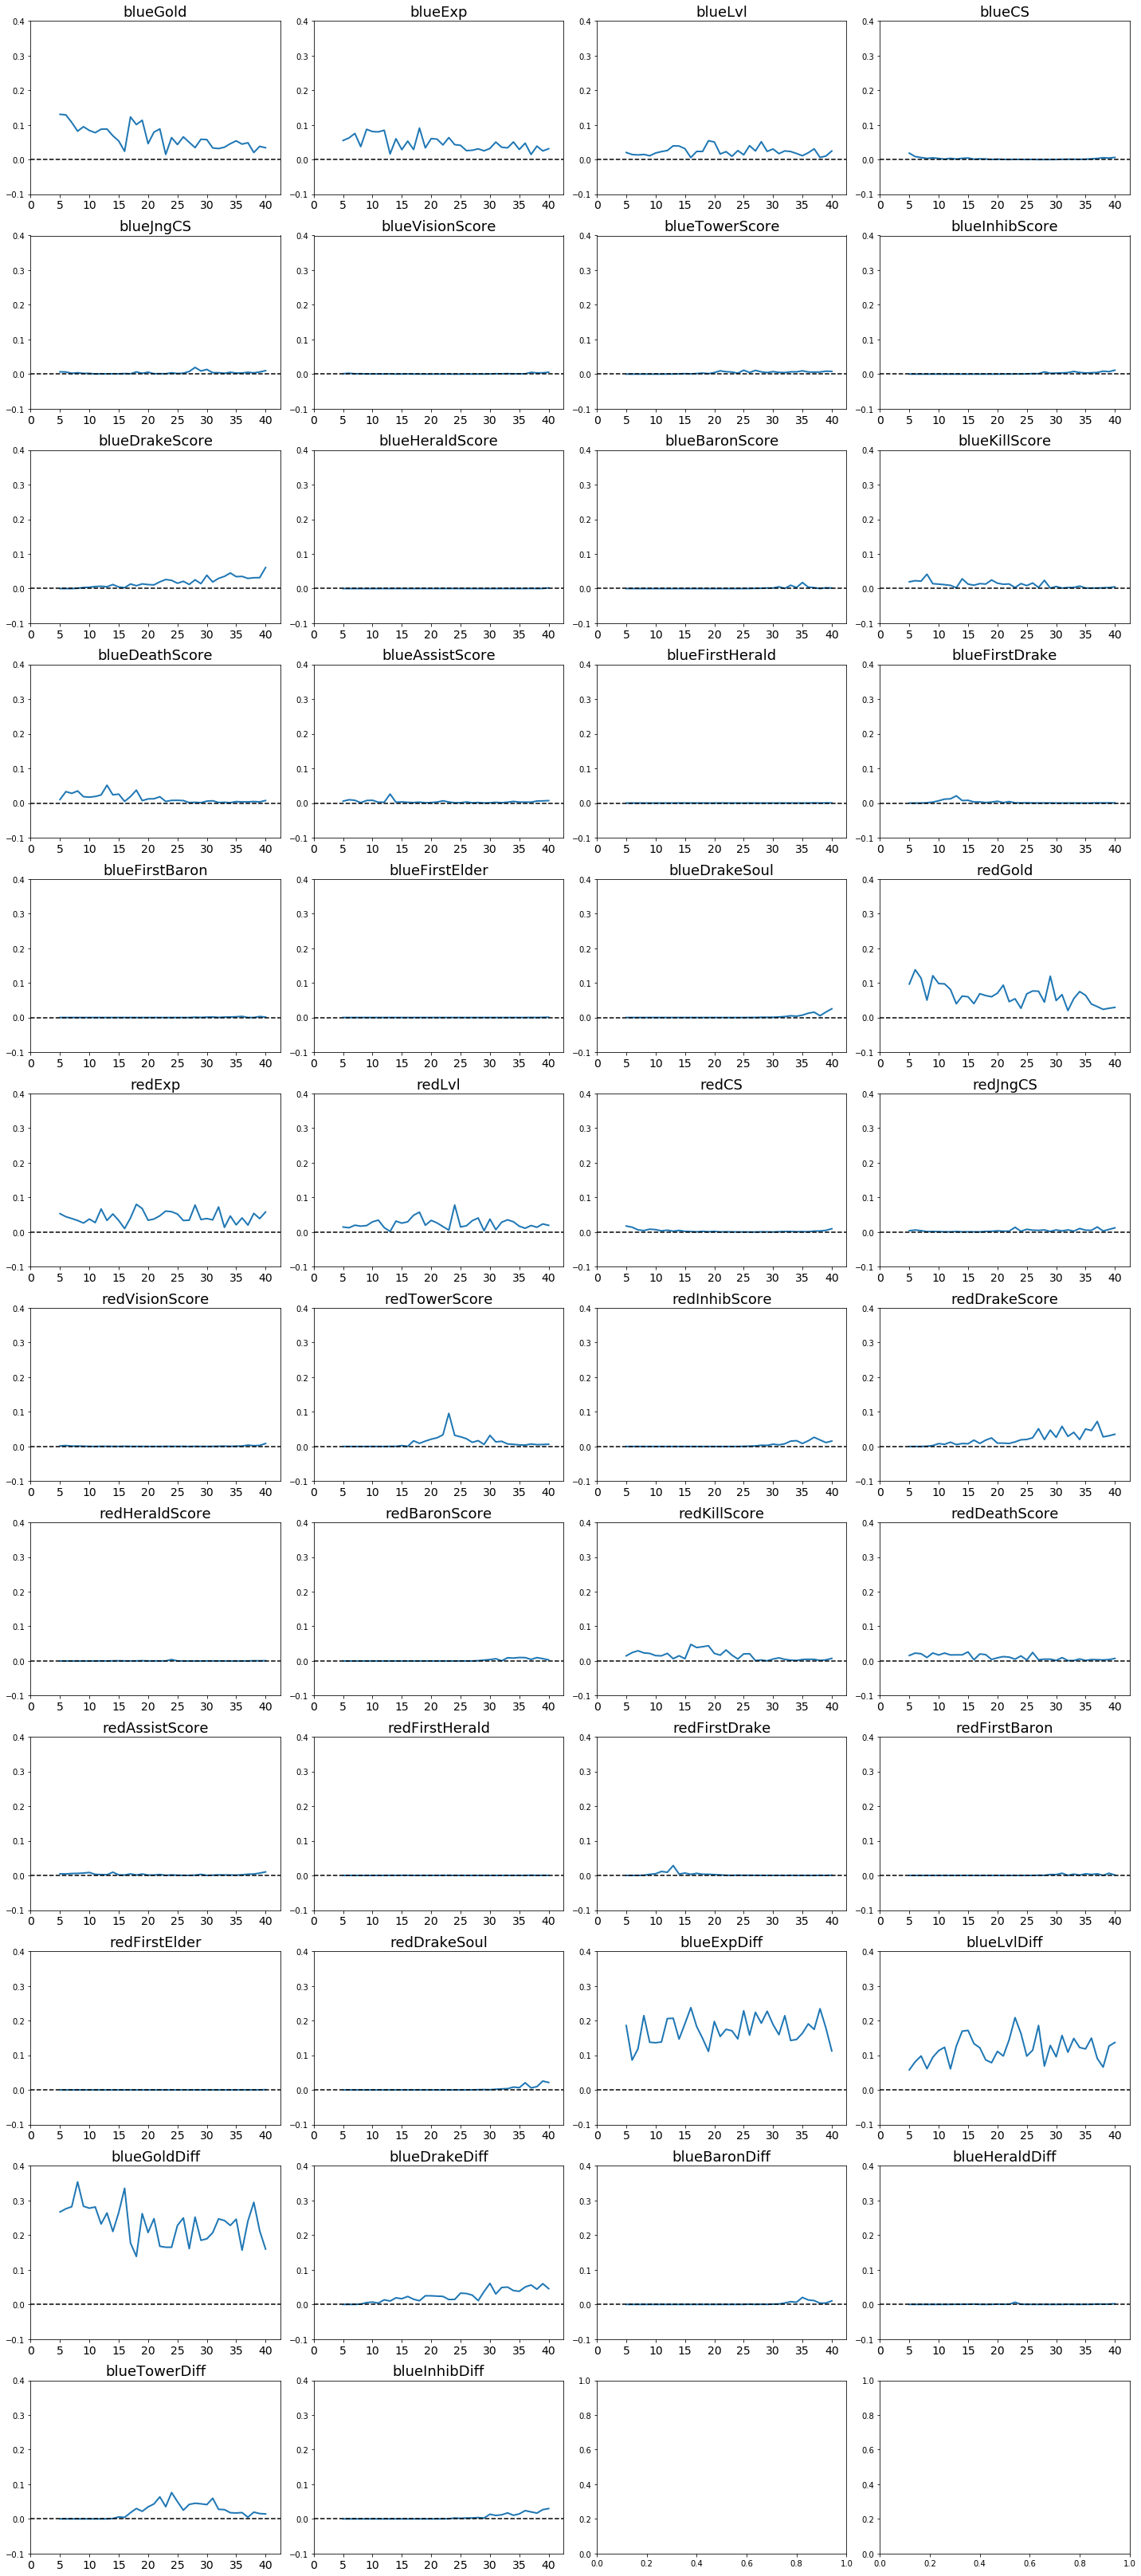

In [21]:
features = list(data_eune["data_5min"].keys())[1:]

coeffs = [clf.feature_importances_ for (time, clf) in classifiers]
coefficients = {key: [] for key in features}

for array in coeffs:
    for (i, key) in enumerate(features):
        coefficients[key].append(array[i])
        
n_rows = 12
n_columns = 4
x_axis = [i+5 for i in range(len(coeffs))]
corr_index = np.array([i for i in range(n_rows*n_columns)]).reshape((n_rows, -1))

fig, ax = plt.subplots(n_rows, n_columns, figsize=(20,45))

for k in range(n_rows):
    for l in range(n_columns):
        try:
            feature = features[corr_index[k, l]]
            ax[k, l].set_title(feature, fontsize=18)
            ax[k, l].plot(x_axis, coefficients[feature], linestyle='-', linewidth=2)
            ax[k, l].set_xlim(0, 42.5)
            ax[k, l].set_xticklabels([0, 5, 10, 15, 20, 25, 30, 35, 40], fontsize=14)
            ax[k, l].set_ylim(-0.1, 0.4)
            ax[k, l].axhline(y = 0, linestyle="--", color="black")
        except:
            pass
plt.tight_layout()      
plt.show()